# 개요
* 참여중인 데이터 엔지니어링 스터디에서 배우는 내용 정리
  * 데이터 수집, 정제 : pyspark, airflow
  * 저장 : elasticsearch
  * 시각화 : kibana

* 3주차 과제 : 정제코드(filter.py) 작성 및 spark-submit해보기

# 과제 - 3주차

* 데이터 확인용 기초코드

In [ ]:
from pyspark.sql import SparkSession

# SparkSession
spark = (
    SparkSession.builder
        .appName("rdd-dataframe")
        .master("local")
        .getOrCreate()
)

# SparkContext를 SparkSession에서 빼두기
sc = spark.sparkContext

# 하단 메시지는 Jupyter 공식이미지에서 나오는 메시지로, 무시하기

24/08/28 14:01:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [ ]:
#json파일로 저장해 둔 스키마 불러오기

import json
from pyspark.sql.types import StructType

# Define the path to the JSON file
input_file_path = 'github_schema.json'

# Open and load the JSON file
with open(input_file_path, 'r') as json_file:
    github_schema = json.load(json_file)

In [ ]:
# 스키마 확인하기

def find_all_names(data, current_path=[]):
    paths = []
    if isinstance(data, dict):
        if 'name' in data:
            # Collect the path to the current 'name'
            paths.append('.'.join(current_path + [data['name']]))
        # Recursively search within this dictionary
        for key, value in data.items():
            if isinstance(value, (dict, list)):
                paths.extend(find_all_names(value, current_path + [data.get('name', key)]))
    elif isinstance(data, list):
        for item in data:
            paths.extend(find_all_names(item, current_path))
    return paths

for each_line in find_all_names(github_schema):
    print(each_line.replace('fields.',''))

In [ ]:
# 저장한 스키마로 파일 읽기 (빠른 확인을 위해 1개의 gh archive데이터만 사용)
from pyspark.sql.types import StructType

schema_to_read = StructType.fromJson(github_schema)
df = spark.read.schema(schema_to_read).json("../data/gh_archive/2024-07-01-14.json.gz")

In [ ]:
# 저장한 스키마로 파일 읽기 (전체파일)
from pyspark.sql.types import StructType

schema_to_read = StructType.fromJson(github_schema)
df = spark.read.schema(schema_to_read).json("../data/gh_archive/2024-07-01-14.json.gz")

In [ ]:
# 데이터 확인

import pyspark.sql.functions as F

columns = ['actor.login','type']
select_exprs = [F.col(col_path).alias(col_path) for col_path in columns]

df2 = df.select(*select_exprs)
df2.show()

+--------------------+--------------------+
|         actor.login|                type|
+--------------------+--------------------+
|       CosmomediaCEO|           PushEvent|
|         ayomide3211|         CreateEvent|
|         julianwagle|           PushEvent|
|               RTann|PullRequestReview...|
|       HttpAnimation|           PushEvent|
|           thunderv3|           PushEvent|
| github-actions[bot]|           PushEvent|
|             aspiers|PullRequestReview...|
| github-actions[bot]|           PushEvent|
|     acciojob-5[bot]|         CreateEvent|
|            dfitzmau|   IssueCommentEvent|
|      steven-bellock|   IssueCommentEvent|
|           rssfeeder|           PushEvent|
|     dependabot[bot]|         CreateEvent|
|    Naveen-Palanivel|         CreateEvent|
|          lukerQuant|   IssueCommentEvent|
|      ZaidQourah2004|         CreateEvent|
|youngZwiebelandth...|           PushEvent|
|    abhishekpaturkar|         CreateEvent|
|       TANGHANHUTNAM|          

## 1. spark-submit.sh 스크립트 참고해서 option 바꾸어보기

* memory옵션들, num-executors, executor-cores 바꿔보기
```
<path-to-spark-submit>/spark-submit \
    --class <project.class.path> \
    --name HelloWorld \    # job name지정
    --master spark://spark-master:7077 \                     # master(현재 실습기준으로는 local)
    --driver-cores 2 \                                       # optimization옵션에 해당
    --driver-memory 2g \                                     # optimization옵션에 해당
    --num-executors 4 \                                      # optimization옵션에 해당
    --executor-cores 2 \                                     # optimization옵션에 해당 (병렬처리를 얼마나 많이 할지)
    --executor-memory 2g \                                   # optimization옵션에 해당
    --conf spark.driver.memoryOverhead=1g                     
    --conf spark.executor.memoryOverhead=1g                  
    --conf spark.dynamicAllocation.enabled=true \            
    --conf spark.dynamicAllocation.executorIdleTimeout=2m \   
    --conf spark.dynamicAllocation.minExecutors=1 \          
    --conf spark.dynamicAllocation.maxExecutors=9 \          
    --conf spark.dynamicAllocation.initialExecutors=1 \      
    --conf spark.memory.offHeap.enabled=true \               
    --conf spark.memory.offHeap.size=2G \                    
    --conf spark.shuffle.service.enabled=true \              
    --conf spark.driver.maxResultSize=0 \                    
    --conf spark.logConf=true \                              
    --jars /opt/bitnami/spark/resources/elasticsearch-spark-302.12-8.4.3.jar
```

* 미사용
  * --class <project.class.path>   # 실행될 기본 클래스 지정
  * --deploy-mode : client/cluster # yarn이 아닌 local환경으로 실습중     

## 2. 원하는 최종 스키마를 만들기 위한 정제 코드 filter.py 작성하기

In [ ]:
# filter.py (main.py에서 import하여, 로딩한 dataframe을 넣고 사용)
class PytorchTopIssuerFilter(BaseFilter):
    def filter(self, df):
        # Filter : repo_name = pytorch
        base_df = df.filter(F.col('userid_and_repo_name') == 'pytorch/pytorch')

        issues_event_exists = base_df.filter(base_df["type"] == "IssuesEvent").count() > 0
        if issues_event_exists:
            filtered_df = base_df.filter(F.col('type') == 'IssuesEvent')
        else:
            return None # 이후 None이 아닌 경우에만 저장 등의 작업을 하도록 main.py 설정

        # groupby
        result_df = filtered_df.groupBy('user_name').pivot('type').count()
        result_df = result_df.cache()
        result_df.where((~F.col('user_name').contains('[bot]'))) \
                    .orderBy(F.desc('IssuesEvent')) \
                    .limit(10)
        return result_df

## 3. 작성한 정제 코드 spark-submit 해보기
* 제출할 내용: spark-submit.sh, filter.py (파일명은 바꾸셔도 무방합니다)

In [ ]:
docker exec -it metacode_de-2024-spark-master-1 spark-submit \
  --master spark://spark-master:7077 \
  --jars /opt/bitnami/spark/resources/elasticsearch-spark-30_2.12-8.4.3.jar \
  jobs/main.py

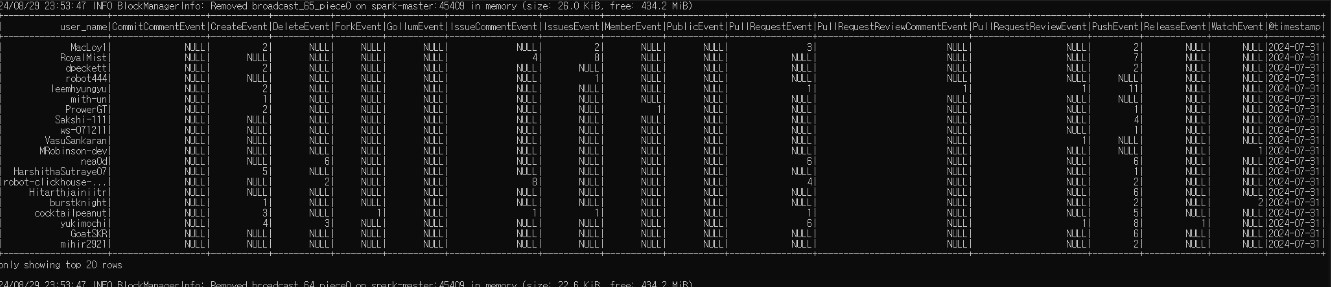